In [ ]:
import argparse
import os
import sys
import pickle
import time
import subprocess
import shutil
sys.path.append(os.getcwd())

from khrylib.utils import *
from khrylib.rl.utils.visualizer import Visualizer
from khrylib.rl.core.policy_gaussian import PolicyGaussian
from khrylib.rl.core.critic import Value
from khrylib.models.mlp import MLP
from motion_imitation.envs.humanoid_im import HumanoidEnv
from motion_imitation.utils.config import Config






In [95]:
env.data.qpos.shape, env.data.qvel.shape, env.model

((39,), (38,), <mujoco_py.cymj.PyMjModel at 0x4a455860>)

In [92]:
cfg = Config('0202', False, create_dirs=False)
cfg_f = Config('0202_freeze', False, create_dirs=False)
cfg_f.obs_type = 'partial'
cfg.env_start_first = True
logger = create_logger(os.path.join(cfg.log_dir, 'log_eval.txt'))

"""make and seed env"""
dtype = torch.float64
torch.set_default_dtype(dtype)
torch.manual_seed(cfg.seed)
torch.set_grad_enabled(False)
env = HumanoidEnv(cfg)
env.seed(cfg.seed)

class HumanoidEnvFreezeKnee(HumanoidEnv):

    def __init__(self, cfg_f, cfg):
        self.cfg = cfg
        self.cfg_f = cfg_f  
        # expert_qpos, expert_meta = pickle.load(open(self.cfg.expert_traj_file, "rb"))

        super().__init__( cfg_f)

        
    def load_expert(self):
        pass
    
    def get_obs(self):
        if self.cfg.obs_type == 'full':
            obs = self.get_full_obs()
        elif self.cfg_f.obs_type == 'partial':
            obs = self.get_partial_obs()
        return obs
    
    def get_partial_obs(self):  # definition of observation for knee
        data = self.data
        qpos = data.qpos.copy()
        qvel = data.qvel.copy()
        print(f"[freez]dim of qpos, qvel = {   qpos.shape, qvel.shape}")
        # transform velocity
        qvel[:3] = transform_vec(qvel[:3], qpos[3:7], self.cfg.obs_coord).ravel()
        obs = []
        # pos
        if self.cfg.obs_heading: # set to False
            obs.append(np.array([get_heading(qpos[3:7])])) 
        if self.cfg.root_deheading: # set to True
            qpos[3:7] = de_heading(qpos[3:7]) 
        obs.append(qpos[2:])
        # vel
        if self.cfg.obs_vel == 'root':
            obs.append(qvel[:6])
        elif self.cfg.obs_vel == 'full': # set to True
            obs.append(qvel)
        # phase
        # if self.cfg.obs_phase:
        #     phase = self.get_phase()
        #     obs.append(np.array([phase]))
        obs = np.concatenate(obs)
        return obs

    def reset_model(self): 
        cfg = self.cfg
        if self.expert is not None:
            ind = 0 if self.cfg.env_start_first else self.np_random.randint(self.expert['len'])
            self.start_ind = ind
            init_pose = self.expert['qpos'][ind, :].copy()
            init_vel = self.expert['qvel'][ind, :].copy()
            init_pose[7:] += self.np_random.normal(loc=0.0, scale=cfg.env_init_noise, size=self.model.nq - 7)# 
            self.set_state(init_pose, init_vel)
            self.bquat = self.get_body_quat()
            # self.update_expert()
        else:
            init_pose = self.data.qpos
            init_pose[2] += 1.0
            self.set_state(init_pose, self.data.qvel)
        return self.get_obs()


env_f = HumanoidEnvFreezeKnee(cfg_f, cfg)
env_f.seed(cfg_f.seed)

actuators = env.model.actuator_names
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

actuators_f = env_f.model.actuator_names
state_dim_f = env_f.observation_space.shape[0]
action_dim_f = env_f.action_space.shape[0]

"""load learner policy"""
policy_net = PolicyGaussian(MLP(state_dim, cfg.policy_hsize, cfg.policy_htype), action_dim, log_std=cfg.log_std, fix_std=cfg.fix_std)
value_net = Value(MLP(state_dim, cfg.value_hsize, cfg.value_htype))
cp_path = '%s/iter_%04d.p' % (cfg.model_dir, 800)
logger.info('loading model from checkpoint: %s' % cp_path)
model_cp = pickle.load(open(cp_path, "rb"))
policy_net.load_state_dict(model_cp['policy_dict'])
value_net.load_state_dict(model_cp['value_dict'])
running_state = model_cp['running_state']

(75, 39)


loading model from checkpoint: results/motion_im/0202/models/iter_0800.p
loading model from checkpoint: results/motion_im/0202/models/iter_0800.p
loading model from checkpoint: results/motion_im/0202/models/iter_0800.p
loading model from checkpoint: results/motion_im/0202/models/iter_0800.p
loading model from checkpoint: results/motion_im/0202/models/iter_0800.p
loading model from checkpoint: results/motion_im/0202/models/iter_0800.p
loading model from checkpoint: results/motion_im/0202/models/iter_0800.p
loading model from checkpoint: results/motion_im/0202/models/iter_0800.p
loading model from checkpoint: results/motion_im/0202/models/iter_0800.p
loading model from checkpoint: results/motion_im/0202/models/iter_0800.p
loading model from checkpoint: results/motion_im/0202/models/iter_0800.p
loading model from checkpoint: results/motion_im/0202/models/iter_0800.p
loading model from checkpoint: results/motion_im/0202/models/iter_0800.p
loading model from checkpoint: results/motion_im/02

[freez]dim of qpos, qvel = ((35,), (34,))


In [84]:
poses = {'pred': [], 'gt': []}
state = env_f.reset()
state, state.shape
# running_state

(array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 (67,))

In [90]:
actuators_f = env_f.model.actuator_names
state_dim_f = env_f.observation_space.shape[0]
action_dim_f = env_f.action_space.shape[0]
len(actuators_f), len(actuators)
state_dim_f, state_dim, action_dim_f, action_dim

(67, 76, 34, 38)

In [85]:
for t in range(1000): 
    
    epos = env.get_expert_attr('qpos', env.get_expert_index(t)).copy()
    print(epos.shape)
    if env.expert['meta']['cyclic']:
        init_pos = env.expert['init_pos']
        cycle_h = env.expert['cycle_relheading']
        cycle_pos = env.expert['cycle_pos']
        epos[:3] = quat_mul_vec(cycle_h, epos[:3] - init_pos) + cycle_pos
        epos[3:7] = quaternion_multiply(cycle_h, epos[3:7])
    poses['gt'].append(epos) 
    poses['pred'].append(env_f.data.qpos.copy())
    state_var = tensor(state, dtype=dtype).unsqueeze(0)
    action = policy_net.select_action(state_var, mean_action=True)[0].cpu().numpy()
    # print(t, state.shape, action.shape)
    next_state, reward, done,info = env.step(action)
    if running_state is not None:
        next_state = running_state(next_state, update=False)
    if done:
        print(f"fail: {info['fail']}")
        break
    state = next_state

poses['gt'] = np.vstack(poses['gt'])
poses['pred'] = np.vstack(poses['pred'])
plot_pose = True
if plot_pose:
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(nrows=poses['gt'].shape[1]//4, ncols=4, figsize=(6, 12))
    for i in range(poses['gt'].shape[1]//4):
        for j in range(4):
            gt = poses['gt'][:, i*4 + j]
            pred = poses['pred'][:, i*4 + j]
            mse = np.mean((gt - pred) ** 2)
            axs[i, j].plot(gt, 'r', label='gt')
            axs[i, j].plot(pred, 'b', label='pred')
            axs[i, j].set_ylim([-np.pi, np.pi])
            axs[i, j].set_title(f'MSE: {mse:.4f}')
            if i == 0 and j == 0:
                axs[i, j].legend()
    plt.tight_layout()
    plt.show()


(39,)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x67 and 76x512)

In [ ]:
qpos = env.expert['qpos']
qpos.shape

(0, 7)

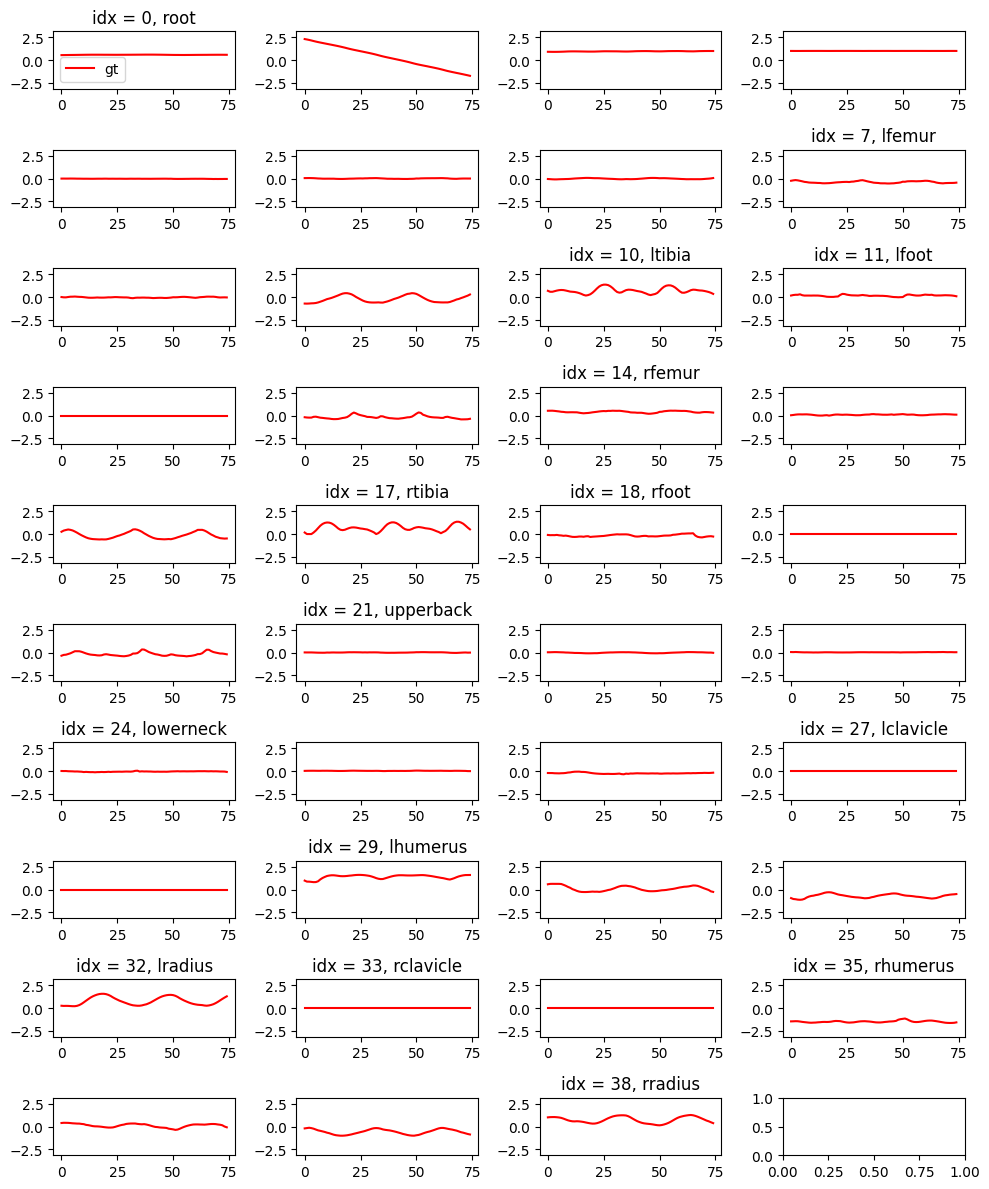

In [ ]:


# import matplotlib.pyplot as plt
# import os
# import sys
# sys.path.append(os.getcwd())

# from khrylib.utils import *
# from mujoco_py import load_model_from_path, MjSim


# model_file = f'khrylib/assets/mujoco_models/mocap_v2.xml'
# model_file_freeze = f'khrylib/assets/mujoco_models/mocap_v2_freeze.xml'
# model = load_model_from_path(model_file)
# model_freeze = load_model_from_path(model_file_freeze)
# sim = MjSim(model)
body_qposaddr = get_body_qposaddr(env.model)
body_qposaddr_list_start_index = [idxs[0] for idxs in list(body_qposaddr.values())]
def plot_qpos(qpos, body_qposaddr_list_start_index):
    fig, axs = plt.subplots(nrows=qpos.shape[1]//4+1, ncols=4, figsize=(10, 12))
    for i in range(qpos.shape[1]//4+1):
        for j in range(4):
            idx = i*4 + j
            if idx >= qpos.shape[1]:
                break
            gt = qpos[:, idx]
            axs[i, j].plot(gt, 'r', label='gt')
            axs[i, j].set_ylim([-np.pi, np.pi])
            if idx in body_qposaddr_list_start_index:
                body_name = [name for name, addr in body_qposaddr.items() if addr[0] == idx][0]
                axs[i, j].set_title(f"idx = {idx}, {body_name}", fontsize=12)
            if i == 0 and j == 0:
                axs[i, j].legend()
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_qpos(qpos, body_qposaddr_list_start_index )

In [94]:
# interpolate each joint
import numpy as np
from scipy.interpolate import interp1d
qpos = env.expert['qpos']
qpos.shape
qpos_interp = interp1d(np.arange(qpos.shape[0]), qpos, axis=0, kind='cubic')
qpos_interp = qpos_interp(np.linspace(0, qpos.shape[0]-1, 1000))
# plot_qpos(qpos_interp)

In [5]:
sim.data.qpos.shape

(39,)

In [12]:
model_file = f'khrylib/assets/mujoco_models/mocap_v2_freeze.xml'
model = load_model_from_path(model_file)
sim = MjSim(model)
body_qposaddr = get_body_qposaddr(model)
body_qposaddr
res = sim.render(255, 255)
# res

array([[[ 80, 181, 120],
        [ 80, 181, 120],
        [ 80, 181, 120],
        ...,
        [ 39, 135,  80],
        [ 39, 135,  80],
        [ 39, 135,  80]],

       [[ 80, 181, 120],
        [ 80, 181, 120],
        [ 80, 181, 120],
        ...,
        [ 39, 135,  80],
        [ 39, 135,  80],
        [ 39, 135,  80]],

       [[ 80, 181, 120],
        [ 80, 181, 120],
        [ 80, 181, 120],
        ...,
        [ 39, 135,  80],
        [ 39, 135,  80],
        [ 39, 135,  80]],

       ...,

       [[ 39, 134,  80],
        [ 39, 134,  80],
        [ 39, 134,  80],
        ...,
        [ 80, 181, 120],
        [ 80, 181, 120],
        [ 80, 181, 120]],

       [[ 39, 134,  80],
        [ 39, 134,  80],
        [ 39, 134,  80],
        ...,
        [ 80, 181, 120],
        [ 80, 181, 120],
        [ 80, 181, 120]],

       [[ 39, 134,  80],
        [ 39, 134,  80],
        [ 39, 134,  80],
        ...,
        [ 80, 181, 120],
        [ 80, 181, 120],
        [ 80, 181, 120]]